# Import Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10-python/cifar-10-python.tar.gz
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar10-python/cifar-10-batches-py/batches.meta
/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar10-python/cifar-10-batches-py/readme.html


# Dataset

In [2]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [3]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
train_ds=tf.data.Dataset.from_tensor_slices((train_images,train_labels))
test_ds=tf.data.Dataset.from_tensor_slices((test_images,test_labels))


# Preprocessing

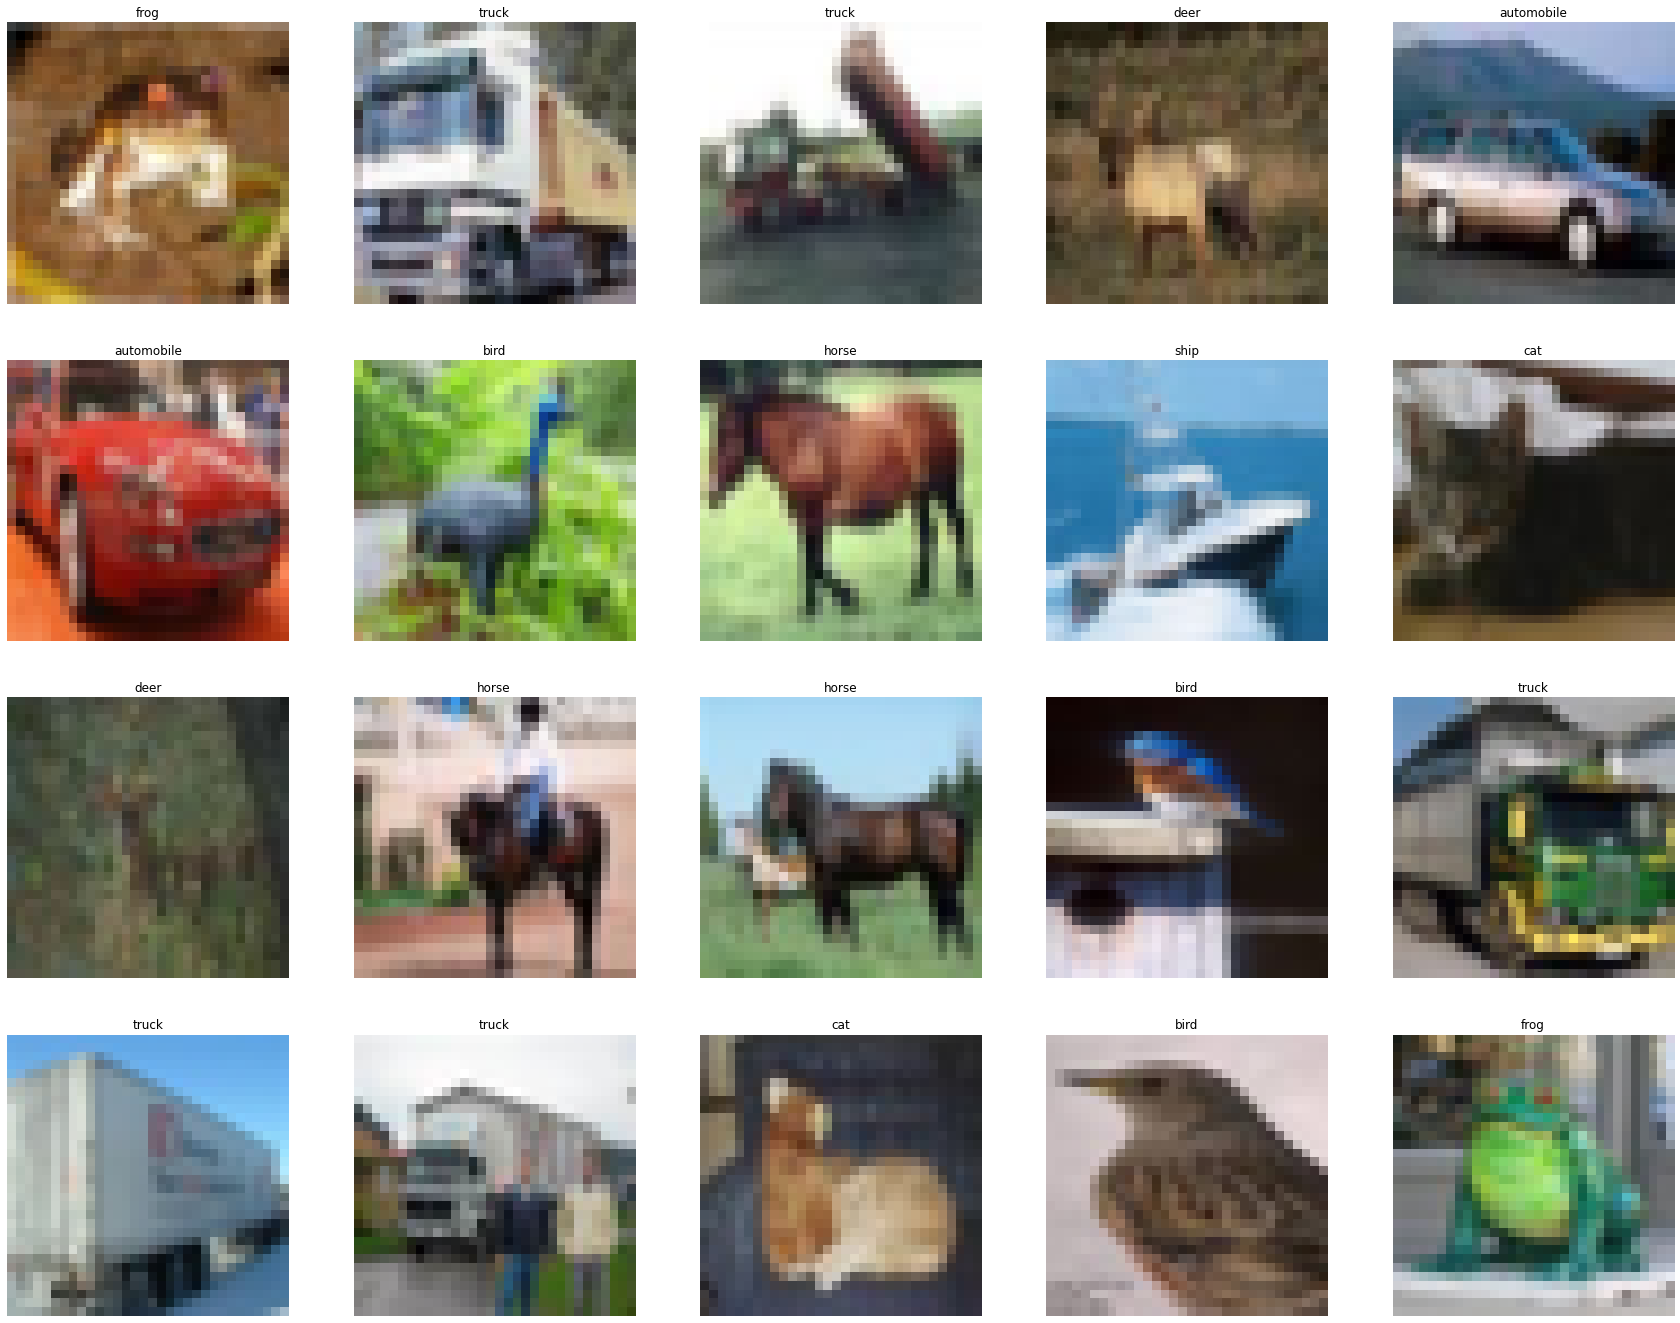

In [5]:
plt.figure(figsize=(30,30))
for i,(image,label) in enumerate(train_ds.take(20)):
    #print(label)
    ax=plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label.numpy()[0]])
    plt.axis('off')

In [6]:
def process_image(image,label):
    image=tf.image.per_image_standardization(image)
    image=tf.image.resize(image,(64,64))
    
    return image,label

# Data Pipeline

In [7]:
train_ds_size=tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size=tf.data.experimental.cardinality(test_ds).numpy()
print('Train size:',train_ds_size)
print('Test size:',test_ds_size)


Train size: 50000
Test size: 10000


In [8]:
train_ds=(train_ds
          .map(process_image)
          .shuffle(buffer_size=train_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )
test_ds=(test_ds
          .map(process_image)
          .shuffle(buffer_size=test_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )

# Build Model

In [9]:
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')  
    
    
])

# Compile Model

In [10]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(lr=0.001),
    metrics=['accuracy']    
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 128)       46592     
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 256)         819456    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 256)         1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 256)         5

# Train Model

In [11]:
class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        # use this value as reference to calculate cumulative time taken
        self.timetaken = time.process_time()
    def on_epoch_end(self,epoch,logs = {}):
        self.times.append((epoch, time.process_time() - self.timetaken))
    def on_train_end(self,logs = {}):
        plt.xlabel('Epoch')
        plt.ylabel('Total time taken until an epoch in seconds')
        plt.plot(*zip(*self.times))
        plt.show()
        from operator import itemgetter
        previous_time = 0
        for item in self.times:
            print("Epoch ", item[0], " run time is: ", item[1]-previous_time)
            previous_time = item[1]
        print("Total trained time is: ", previous_time)

timetaken = timecallback()
callbacks = [
    # This callback saves a SavedModel every epoch
    # We include the current epoch in the folder name.
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(os.getcwd(), "ckpt-{epoch}"), save_freq="epoch"
    ),
    timetaken
]

Epoch 1/50
1562/1562 [==============================] - 15s 10ms/step - loss: 2.1882 - accuracy: 0.2344 - val_loss: 1.7000 - val_accuracy: 0.3839
Epoch 2/50
1562/1562 [==============================] - 14s 9ms/step - loss: 1.8091 - accuracy: 0.3380 - val_loss: 1.5642 - val_accuracy: 0.4342
Epoch 3/50
1562/1562 [==============================] - 14s 9ms/step - loss: 1.6583 - accuracy: 0.3949 - val_loss: 1.4668 - val_accuracy: 0.4742
Epoch 4/50
1562/1562 [==============================] - 14s 9ms/step - loss: 1.5506 - accuracy: 0.4405 - val_loss: 1.3985 - val_accuracy: 0.5028
Epoch 5/50
1562/1562 [==============================] - 14s 9ms/step - loss: 1.4544 - accuracy: 0.4753 - val_loss: 1.3850 - val_accuracy: 0.5044
Epoch 6/50
1562/1562 [==============================] - 14s 9ms/step - loss: 1.3742 - accuracy: 0.5042 - val_loss: 1.2802 - val_accuracy: 0.5481
Epoch 7/50
1562/1562 [==============================] - 14s 9ms/step - loss: 1.2990 - accuracy: 0.5300 - val_loss: 1.3172 - val_a

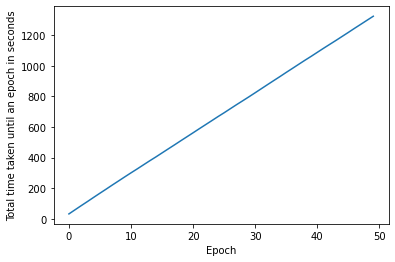

Epoch  0  run time is:  31.222499126
Epoch  1  run time is:  27.36886701500001
Epoch  2  run time is:  27.273431668
Epoch  3  run time is:  26.748249922
Epoch  4  run time is:  27.382988158000003
Epoch  5  run time is:  26.959675033999986
Epoch  6  run time is:  26.600404765000008
Epoch  7  run time is:  27.16394459700001
Epoch  8  run time is:  26.466614859000003
Epoch  9  run time is:  26.700363171999953
Epoch  10  run time is:  26.278767787999982
Epoch  11  run time is:  25.741232586000024
Epoch  12  run time is:  26.444290103000014
Epoch  13  run time is:  26.36364263600001
Epoch  14  run time is:  25.42165923699997
Epoch  15  run time is:  26.491718794000008
Epoch  16  run time is:  26.370580691999976
Epoch  17  run time is:  26.161294234000025
Epoch  18  run time is:  26.67684318499994
Epoch  19  run time is:  26.252035067000065
Epoch  20  run time is:  26.367806478000034
Epoch  21  run time is:  26.586920577
Epoch  22  run time is:  26.231118807999906
Epoch  23  run time is:  26

In [12]:
history=model.fit(
    train_ds,
    epochs=50,
    callbacks=callbacks,
    validation_data=test_ds,
    validation_freq=1
)

In [13]:
model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

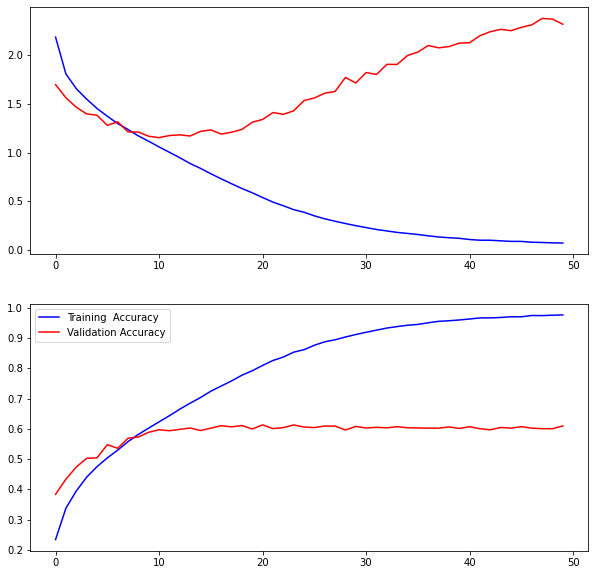

In [14]:
f,ax=plt.subplots(2,1,figsize=(10,10)) 

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()

In [15]:
print('Accuracy Score = ',np.max(history.history['val_accuracy']))

Accuracy Score =  0.6133813858032227
